In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


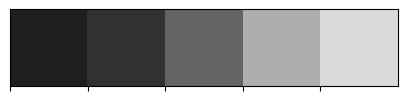

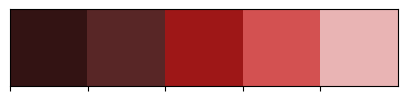

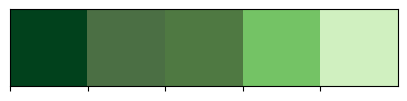

In [ ]:
#odredi boje
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_red)
sns.palplot(colors_green)

In [ ]:
#odredi kategorije
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

In [ ]:
#odredi 2 niza, x za svem yslike, y za sve nazive. Pa zatim prodji
#kroz sve foldere i stavi sve djuture u ta dva niza
# '/Users/user/Desktop/Kaggle data sets/brain_tumor/Data'

X_train = []
Y_train = []
image_size = 150

folderPath = '/content/drive/MyDrive/Colab Notebooks/brain_tumor/Data/'
for i in labels:
    folderPath = os.path.join(folderPath, 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img_name = os.path.join(folderPath, j)
        img = cv2.imread(img_name)
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)


for i in labels:
    folderPath = os.path.join(folderPath, 'Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img_name = os.path.join(folderPath, j)
        img = cv2.imread(img_name)
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)

X_train = np.array(X_train)
Y_train = np.array(Y_train)


100%|██████████| 74/74 [00:26<00:00,  2.77it/s]


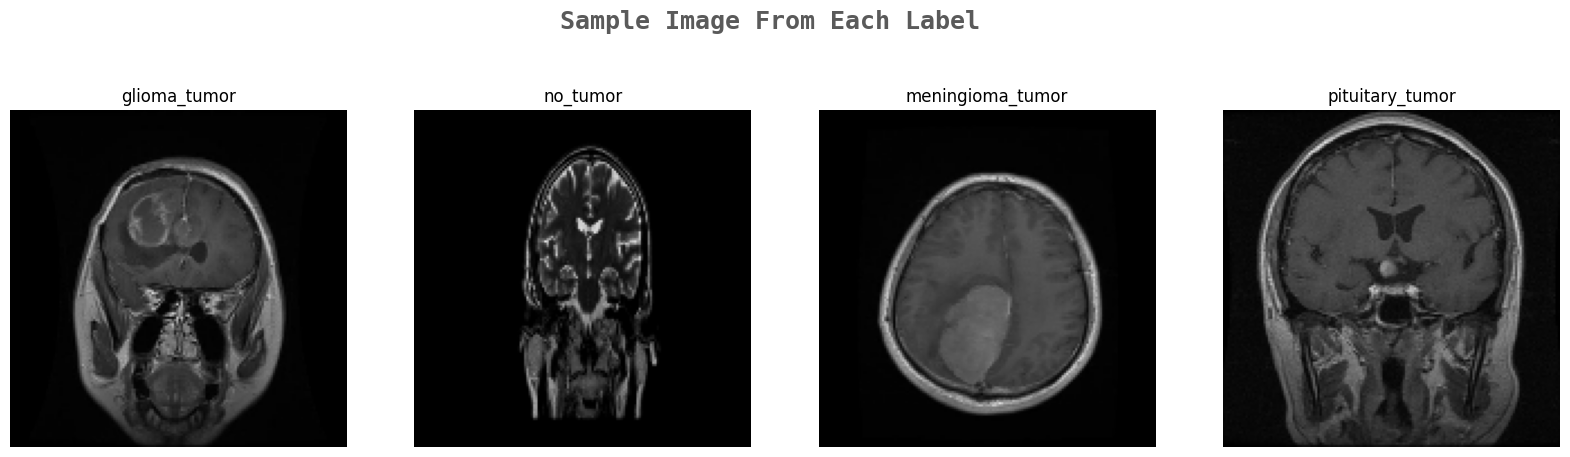

In [ ]:
#uzmi i vidi da li si ti do dobro uradio i pogledaj primere za tvoj datasetb

k = 0
fig, ax = plt.subplots(1,4, figsize=(20, 20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
         fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)


for i in labels:
    j = 0
    while True:
        if Y_train[j] == i:
            ax[k].axis('off')
            ax[k].set_title(Y_train[j])
            ax[k].imshow(X_train[j])
            k += 1
            break
        j += 1





In [ ]:
X_train, Y_train = shuffle (X_train,Y_train, random_state = 69)

In [ ]:
X_train.shape

(3264, 150, 150, 3)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 1312)

In [ ]:
Y_train_new = []
for i in Y_train:
    Y_train_new.append(labels.index(i))
Y_train = Y_train_new
Y_train = tf.keras.utils.to_categorical(Y_train)

Y_test_new = []
for i in Y_test:
    Y_test_new.append(labels.index(i))
Y_test = Y_test_new
Y_test = tf.keras.utils.to_categorical(Y_test)


In [ ]:
effnet = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (image_size, image_size, 3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate = 0.5)(model)
model = tf.keras.layers.Dense(4, activation = 'softmax')(model)
model = tf.keras.models.Model(inputs = effnet.input, outputs = model)



In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5", monitor = 'val_accuracy', save_best_only = True, mode = "auto", verbose = 1)
reduce_lr =  ReduceLROnPlateau (monitor = 'val_accuracy', factor = 0.3,  patience = 2, min_delta = 0.001,
                               mode = 'auto', verbose = 1)

In [ ]:
history = model.fit(X_train, Y_train, validation_split = 0.1, epochs = 12, verbose = 1, batch_size = 32,
                   callbacks = [tensorboard, checkpoint, reduce_lr])


Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.8241
Epoch 1: val_accuracy improved from -inf to 0.80272, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 64s 197ms/step - loss: 0.4634 - accuracy: 0.8241 - val_loss: 0.7862 - val_accuracy: 0.8027 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9436
Epoch 2: val_accuracy improved from 0.80272 to 0.88776, saving model to effnet.h5
83/83 [==============================] - 13s 151ms/step - loss: 0.1595 - accuracy: 0.9436 - val_loss: 0.5044 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.9554
Epoch 3: val_accuracy did not improve from 0.88776
83/83 [==============================] - 11s 138ms/step - loss: 0.1298 - accuracy: 0.9554 - val_loss: 0.5809 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.0778 - accuracy: 0.9758
Epoch 4: val_accuracy did not improve from 0.88776

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 [===============

Text(0, 0.5, 'Accuracy')

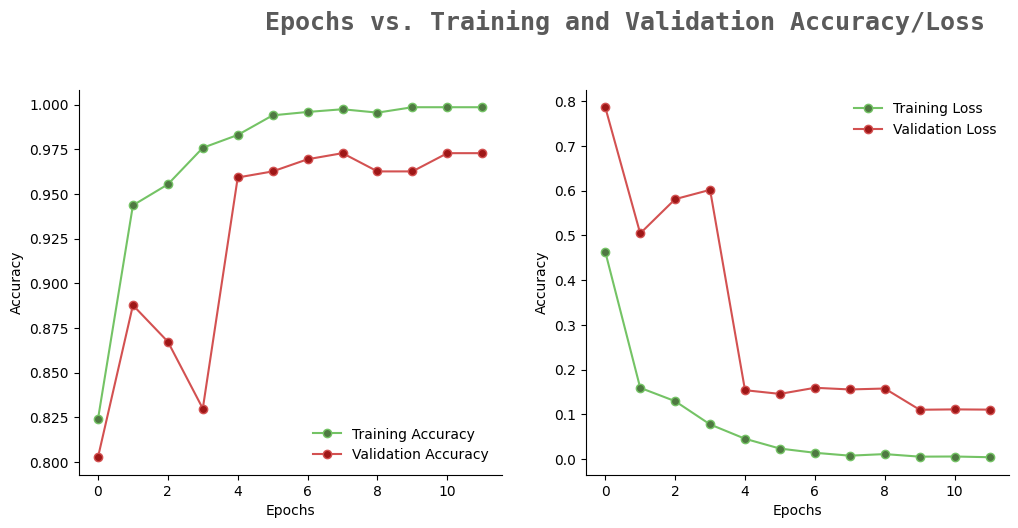

In [40]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)
sns.despine()
ax[0].plot(epochs, train_acc, marker = 'o', markerfacecolor = colors_green[2], color = colors_green[3],
           label = 'Training Accuracy')

ax[0].plot(epochs, val_acc, marker = 'o', markerfacecolor = colors_red[2], color = colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon = False)

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, marker = 'o', markerfacecolor = colors_green[2], color = colors_green[3],
           label = 'Training Loss')

ax[1].plot(epochs, val_loss, marker = 'o', markerfacecolor = colors_red[2], color = colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon = False)

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

In [42]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis= 1)
Y_test_new = np.argmax(Y_test, axis =1 )

11/11 [==============================] - 0s 36ms/step


In [43]:
print(classification_report(Y_test_new, pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        84
           1       0.97      0.95      0.96        61
           2       0.96      0.96      0.96        94
           3       0.98      1.00      0.99        88

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



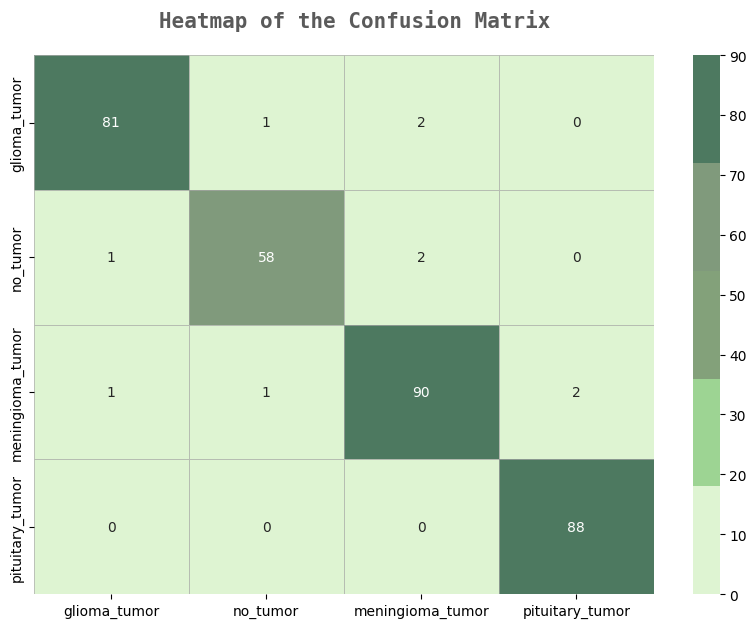

In [58]:
fig, ax = plt.subplots(1,1, figsize=(10, 7, ))
sns.heatmap(confusion_matrix(Y_test_new, pred), ax = ax, xticklabels = labels, yticklabels = labels, annot=True,
            cmap = colors_green[::-1], alpha = 0.7, linewidths =0.5,  linecolor = colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=15,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.25,alpha=0.8)
plt.show()

In [60]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [63]:

uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [64]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])